# Dispersion coefficients from TDDFT (example with PySCF)

Dispersion interaction is a weak attractive interaction that binds even neutral, noble gas atoms to each other. Dispersion interaction sometimes mistakenly called the van der Waals (vdW) interaction, which is not correct. VdW-interactions are a combination of intermolecular interactions, where permanent molecular dipoles induce and interact with other molecular dipoles. Despite being the weakest form of van der Waals forces, dispersion interactions significantly influence the structure, stability, and properties of molecular systems, including biological molecules like proteins and DNA. 

Dispersion interaction is caused by fluctuations in the electron densities in an atom or a molecule. The fluctuations cause intantaneous electric fields that are felt by ther nearby atoms or molecules, which respond to the electric field by adjusting their own electron densities accordingly. These instantaneous dipole moments then attract each other, resulting in the dispersion interaction. 

While other van der Waals force are well described by the computational chemistry workhorse, the density functional theory (DFT), the dispersion interaction is not. Traditional DFT methods struggle to accurately predict dispersion interaction, because the electron-electron interaction is only treated approximately, without directly accounting for the correlated motion of electrons. Instead, the dispersion is usually included in the DFT calculations as a separate correction. Using the Rayleigh--Schrödinger perturbation theory, one can show that the potential energy between two weakly interacting systems is proportional to the inverse sixth power of the distance between them, leading to the well-known 

$$V(r) \propto -\frac{C_6}{r^6}$$ 

where $C_6$ is the dispersion coefficient and $r$ is the intermolecular distance.

Here, we will have a look at how the dispersion coefficient $C_6$ can be computed using time-dependent density functional theory (TD-DFT) by PySCF. We will also explore the basis set dependence of the results and how the commonly employed Tamm-Dancoff approximation (TDA) affects the results.

### Oscillator strengths


Oscillator strength describes the probability for transition between quantum states when a photon is absorbed (or emitted),

$$f_n = \frac{2}{3} \omega_{n0}^A\left|\left<{\phi_0^A|\mathbf{r}|\phi_n^A}\right>\right|^2$$

where $f_n$ is the oscillator strength for a transition from the ground state to the $n$th excited state, $\omega_n$ is the corresponding transition energy and $\left|\left<{\phi_0^A|\mathbf{r}|\phi_n^A}\right>\right|^2$ is the squared magnitude for the transition dipole moment vector of the excitation. 

In fact, one can use Rayleigh--Schrödinger perturbation theory to derive an expression for the dispersion interaction between two systems $A$ and $B$ separated by a large distance $R$ with no overlap:

$$
U_\text{disp} = -\frac{C_6}{R^6}
$$


$$
C^{AB}_6 = \sum_{n\neq0}\sum_{m\neq0}\frac{\left|\left<{\phi_0^A|\mathbf{r}|\phi_n^A}\right>\right|^2\left|\left<{\phi_0^B|\mathbf{r}|\phi_m^B}\right>\right|^2}{\omega_{n0}^A + \omega_{m0}^B} = \frac{3}{2}\sum_{n\neq0}\sum_{m\neq0}\frac{f_{n0}^A f_{m0}^B}{\omega_{n0}^A\omega_{m0}^B(\omega_{n0}^A + \omega_{m0}^B)},
$$

where $\omega_{m0} = E_m-E_0$.

Here we will use the last sum to compute the dispersion coefficient $C_6$ for a methane molecule.

### PySCF

We will use PySCF to compute the excitation spectra and oscillator strenghts using time-dependent density functional theory (TD-DFT). First we'll compute the ground state energy of a methane molecule using $\omega$B97X exchange--correlation functional and a diffuse triple-$\zeta$ basis set def2-TZVPD.

In [55]:
from pyscf import gto, scf, tdscf, dft, tddft
import matplotlib.pyplot as plt
import numpy as np

# Define molecule and basis set
mol = gto.Mole()
mol.atom = 'H 0.5349075 0.1628792 0.9466881; \
            H 0.2074921 0.8335188 -0.6864069; \
            H 0.3383696 -0.9421607 -0.4547893; \
            H -1.0808570 -0.0543245 0.1943354; \
            C -0.0000122 -0.0000128 -0.0000272'
mol.basis = 'def2-tzvpd'
mol.build()

# Run DFT calculation
mf = scf.RKS(mol)
mf.xc = 'wB97x'
mf.verbose = 0
mf.run()

Next, we'll compute the full excitation spectra using the TDDFT module of PySCF. We can define how many excitations are included by the \emph{nstates} variable. The maximum is determined by the dimension of our basis set.

In [56]:
# Run TDDFT calculation
td = tddft.TDDFT(mf)
td.nstates = 450  # Number of excitations included
td.verbose = 0
td.run()

Let's look at how the Thomas--Reiche--Kuhn sum rule is reproduced by our spectra. The TRK sum rule states that the sum of the oscillator strenghts should equal the number of particles in the system, i.e. 

$$\sum_n f_n = N.$$

In [57]:
# Extract excitation energies (in a.u.) and oscillator strengths
excitation_energies = np.array(td.e)
oscillator_strengths = np.array(td.oscillator_strength(gauge='length', order=0))

print(f'Thomas-Reiche-Kuhn sum rule: {oscillator_strengths.sum(): .3f}')
print(f'Number of electrons: {np.sum(mol.nelec)}')

Thomas-Reiche-Kuhn sum rule:  8.847
Number of electrons: 10


The sum rule and the number of electrons done exactly match. We'll come back to this a bit later. However, using the sum for the dispersion coefficients, presented above, we can compute the dispersion coefficient for the methane molecule.

In [58]:
N = M = len(excitation_energies)

C6 = 0
for n in range(N):
    wn = excitation_energies[n]
    for m in range(M):
        wm = excitation_energies[m]
        C6 += oscillator_strengths[n]*oscillator_strengths[m] / (wn*wm * (wn+wm)) * 3./2.
print(f'Dispersion coefficient: {C6: .3f}')

Dispersion coefficient:  126.347


The computed dispersion coefficient is excellent good agreement with the experimental value of 129.6 measured using dipole oscillator strength distribution (see https://doi.org/10.1080/00268978000103781).

An alternative scheme for computing the dispersion coefficient between system $A$ and $B$ is by the Casimir--Polder equation, 

$$C_6^{AB} = \frac{3}{\pi} \int_0^\infty \alpha^A(i\omega)\alpha^B(i\omega)d\omega$$


where $\alpha^{A/B}(\omega)$ is the dynamic polarizability of system $A/B$.

We can construct the dynamic polarizability from the oscillator strengths, using

$$\alpha^A(\omega) = \sum \frac{f_n^A}{\omega_n^2-\omega^n}.$$


(For more details, see the discussion by Langhoff and Karplus in *The Pade Approximant in Theoretical Physics*.)

In [24]:
# Construct dynamic polarizability
frequencies = np.linspace(0, 30, 300)
alpha = np.zeros(frequencies.shape)

for k in range(len(excitation_energies)):
    alpha += oscillator_strengths[k] / (excitation_energies[k]**2 + frequencies**2) # The imaginary frequency is accounted for in the sum

C6_alpha = np.trapz(alpha*alpha*3/np.pi, frequencies) # Integrate over the frequencies
print(C6_alpha)

126.34656702984459


### Tamm-Dancoff approximation

In TDDFT, the full excitation spectra considered contains both excitations and de-excitations. However, the excitations and de-excitations are somewhat redundant and de-excitations are often ignored to ease the computational burden. This is called the Tamm-Dancoff approximation. TDA is often regarded as a reasonable approximation that, in some instances, provides stabilization to the calculation and even improves the computed excitation spectra.

Let's switch the full TDDFT to TDA and see what we get.

In [50]:
# Run TDA calculation
td = tddft.TDA(mf)
td.nstates = 350  # Number of excitations included
td.verbose = 0
td.run()

excitation_energies_tda = np.array(td.e)
oscillator_strengths_tda = np.array(td.oscillator_strength(gauge='length', order=0))
print(f'Thomas-Reiche-Kuhn sum rule for TDA: {oscillator_strengths_tda.sum(): .3f}')
print(f'Number of electrons: {np.sum(mol.nelec)}')

N = M = len(excitation_energies)

C6 = 0
for n in range(N):
    wn = excitation_energies_tda[n]
    for m in range(M):
        wm = excitation_energies_tda[m]
        C6 += oscillator_strengths_tda[n]*oscillator_strengths_tda[m] / (wn*wm * (wn+wm)) * 3./2.
print(f'Dispersion coefficient: {C6: .3f}')

Thomas-Reiche-Kuhn sum rule for TDA:  11.374
Number of electrons: 10
Dispersion coefficient:  107.405


The dispersion coefficient is well off the mark! Also the TRK sum is larger than the number of electrons in the system. Why is this?

If we compare the excitation spectra and the oscillator strengths for full TDDFT and with TDA, we see that while the excitation spectra from both methods agree with each other, the oscillator strenghts do not. This discrepancy results in a poor accuracy for the dispersion coefficient (and dynamic polarizability).

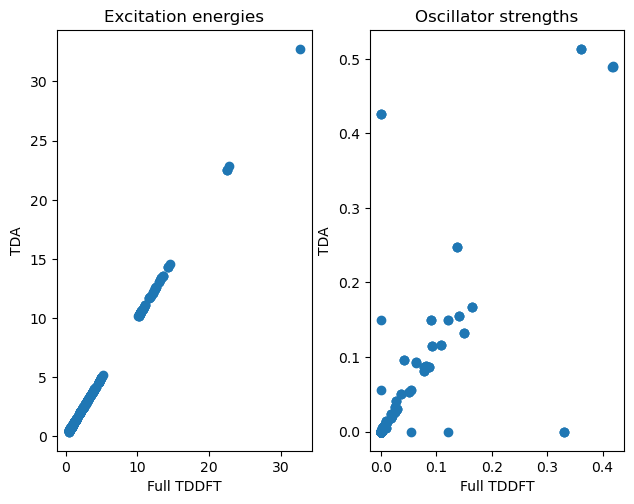

In [45]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout()
ax1.plot(excitation_energies, excitation_energies_tda, 'o')
ax1.set_title('Excitation energies')
ax1.set_xlabel("Full TDDFT")
ax1.set_ylabel("TDA")
ax2.plot(oscillator_strengths, oscillator_strengths_tda, 'o')
ax2.set_title('Oscillator strengths')
ax2.set_xlabel("Full TDDFT")
ax2.set_ylabel("TDA")
plt.show()

### Basis set dependence

A diffuse basis set is in general a must when computing excited states, especially in post-Hartree-Fock theory, must also in TDDFT. If we switch to a smaller basis set (such as def2-TZVP or even def2-SVP), our estimate for the dispersion coefficient becomes significantly much poorer. Interestingly, the TRK sum rule is more closer to $N$. 